In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_dt = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
year_ago = latest_date_dt.date() - dt.timedelta(days=365)
result = calc_temps(year_ago, latest_date_dt)
print(result)

[(58.0, 74.59058295964125, 87.0)]


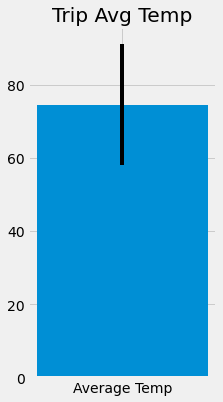

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize = (3,6))
plt.bar('Average Temp',result[0][1],width=0.1,yerr =result[0][0] - result[0][1] )
plt.title('Trip Avg Temp')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
CombinedDataSet = session.query(Station.name, Station.id, Station.latitude, Station.longitude,Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= latest_date_dt).\
    group_by(Station.name).\
    order_by(desc(func.sum(Measurement.prcp))).all()
print(CombinedDataSet)

[('MANOA LYON ARBO 785.2, HI US', 9, 21.3331, -157.8025, 152.4, 147.81000000000006), ('WAIHEE 837.5, HI US', 7, 21.45167, -157.84888999999998, 32.9, 70.03000000000003), ('KANEOHE 838.1, HI US', 2, 21.4234, -157.8015, 14.6, 48.510000000000026), ('WAIMANALO EXPERIMENTAL FARM, HI US', 6, 21.33556, -157.71139, 19.5, 38.01), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 3, 21.5213, -157.8374, 7.0, 33.239999999999995), ('WAIKIKI 717.2, HI US', 1, 21.2716, -157.8168, 3.0, 16.089999999999986), ('PEARL CITY, HI US', 4, 21.3934, -157.9751, 11.9, 4.59)]


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-07'

# Use the start and end date to create a range of dates
datelist = pd.date_range(start_date, end_date).tolist()
# Strip off the year and save a list of strings in the format %m-%d
month_date= []
for date in datelist:
    month_date.append(date.strftime('%m-%d'))

# Use the `daily_normals` function to calculate the normals for each date string 
normals = []
for date in month_date:
    daily_value = daily_normals(date)
    normals.append(daily_value[0])
# and append the results to a list called `normals`.
print(normals)

[(62.0, 69.15384615384616, 77.0), (60.0, 69.39622641509433, 77.0), (62.0, 68.9090909090909, 77.0), (58.0, 70.0, 76.0), (56.0, 67.96428571428571, 76.0), (61.0, 68.96491228070175, 76.0), (57.0, 68.54385964912281, 76.0)]


In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
daily_normals['date'] = month_date
daily_normals = daily_normals.set_index('date')
print(daily_normals)

       tmin       tavg  tmax
date                        
01-01  62.0  69.153846  77.0
01-02  60.0  69.396226  77.0
01-03  62.0  68.909091  77.0
01-04  58.0  70.000000  76.0
01-05  56.0  67.964286  76.0
01-06  61.0  68.964912  76.0
01-07  57.0  68.543860  76.0


In [16]:
print(daily_normals['tmax'])

date
01-01    77.0
01-02    77.0
01-03    77.0
01-04    76.0
01-05    76.0
01-06    76.0
01-07    76.0
Name: tmax, dtype: float64


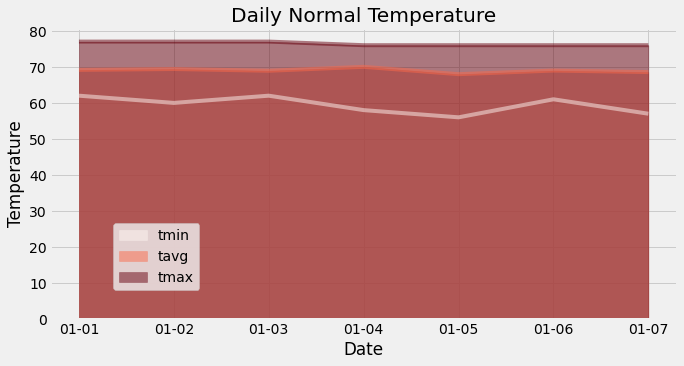

In [17]:
daily_normals.plot(kind='area', stacked= False, alpha=0.5, colormap='Reds',figsize = (10, 5))
plt.legend(loc=(0.1, 0.1))
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title("Daily Normal Temperature")
plt.show()

## Close Session

In [18]:
session.close()